In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt

## Lecture 15: Nearest Neighbor

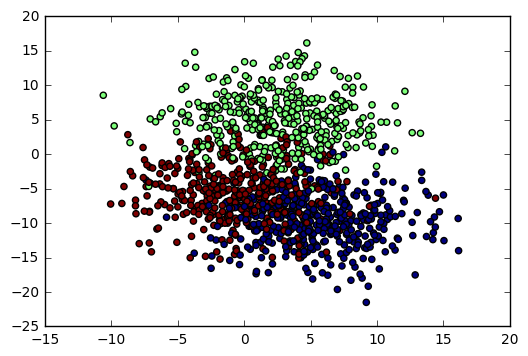

In [2]:
plt.jet() # set the color map. When your colors are lost, re-run this.
import sklearn.datasets as datasets
X, Y = datasets.make_blobs(n_samples=1200, n_features=2, 
                           centers=3, cluster_std=4.0, random_state=10)
plt.scatter(X[:,0], X[:,1], c=Y);

In [3]:
def train_val_test_split(X,Y,n_test=100,n_val=100):
    from sklearn.cross_validation import StratifiedShuffleSplit
    # create test set
    sss = StratifiedShuffleSplit(Y, n_iter=1, test_size=n_test, 
                                 random_state=0)
    for train_idx, test_idx in sss:
        X_train = X[train_idx,:]
        Y_train = Y[train_idx]
        X_test = X[test_idx,:]
        Y_test = Y[test_idx]  
    # create train / val
    X = X_train
    Y = Y_train
    sss2 = StratifiedShuffleSplit(Y, n_iter=1, test_size=n_val, 
                                  random_state=111)
    for train_idx, val_idx in sss2:
        X_train = X[train_idx,:]
        Y_train = Y[train_idx]
        X_val = X[val_idx,:]
        Y_val = Y[val_idx]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [4]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = train_val_test_split(X,Y)

/Users/tow02/Desktop/iccs413/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Build k-Nearest Neighbor models

In [5]:
from sklearn import neighbors
k = 3
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(k, weights=weights)
clf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [6]:
def plot_decision_boundary(clf,X,Y,h=0.04):
    from matplotlib.colors import ListedColormap

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')" % 
              (k, weights))

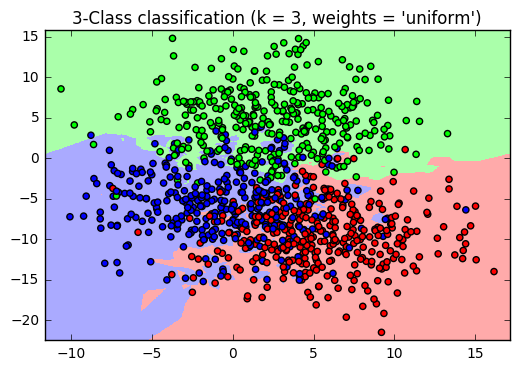

In [7]:
plot_decision_boundary(clf, X_train, Y_train)

In [8]:
k = 7
weights = 'uniform'
clf2 = neighbors.KNeighborsClassifier(k, weights=weights)
clf2.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

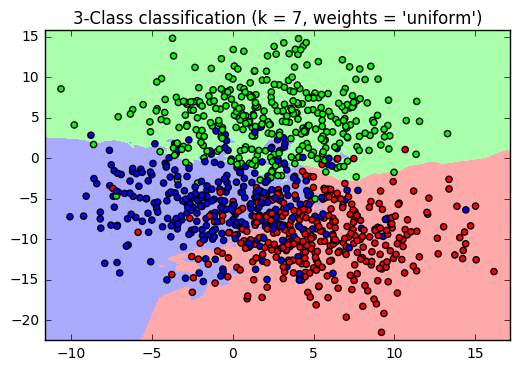

In [9]:
plot_decision_boundary(clf2, X_train, Y_train)

## Test errors

In [10]:
k = 3
clf = neighbors.KNeighborsClassifier(k)
clf.fit(X_train, Y_train)

error_rate = sum(clf.predict(X_test) != Y_test)/float(len(Y_test))
print "error rate = %f" % error_rate

error rate = 0.200000


### Tuning for the parameter K

In [11]:
errors = []
for k in range(1,20):
    clf = neighbors.KNeighborsClassifier(k)
    clf.fit(X_train, Y_train)
    errors.append(sum(clf.predict(X_val) != Y_val)/float(len(Y_val)))

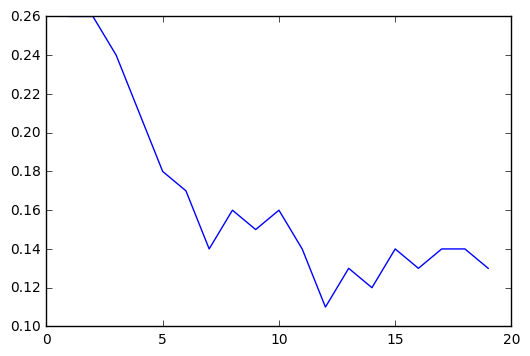

In [12]:
plt.plot(range(1,20),errors)

From the plot, we choose k = 12

In [13]:
k = 12
clf = neighbors.KNeighborsClassifier(k)
clf.fit(X_train, Y_train)

error_rate = sum(clf.predict(X_test) != Y_test)/float(len(Y_test))
print "error rate = %f" % error_rate

error rate = 0.190000


## MNIST

<img src="mnistExamples.png">

In [14]:
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
X_digits, _,_, Y_digits = fetch_mldata("MNIST Original").values() # fetch dataset from internet
X_digits, Y_digits = shuffle(X_digits,Y_digits) # shuffle dataset (which is ordered!)
X_digits = X_digits[-5000:,:] 
Y_digits = Y_digits[-5000:]
X_train, Y_train, X_val, Y_val, X_test, Y_test = train_val_test_split(
    X_digits,Y_digits, 1000, 1000)

In [15]:
from sklearn import neighbors
k = 5
clf = neighbors.KNeighborsClassifier(k)
clf.fit(X_train, Y_train)

error_rate = sum(clf.predict(X_test) != Y_test)/float(len(Y_test))
print "error rate = %f" % error_rate

error rate = 0.075000


## k-nearest Neighbors

- classification
- predict by taking a majority vote among k-"**nearest**" neighbors
- need a distance function: $ \sqrt{(dx)^2 + (dy)^2} $

## The curse of dimensionality

In [16]:
def genPoint(n):
    return np.random.randn(n)

def distance(p1, p2):
    return np.linalg.norm(p1-p2)


In [17]:
def random_distances(dim, n_points):
    return [distance(genPoint(dim), genPoint(dim)) for _ in range(n_points)]

In [18]:
dimensions = range(1, 1000)
avg_distances = []
min_distances = []
for dim in dimensions:
    distances = random_distances(dim, 1000)
    avg_distances.append(np.mean(distances))
    min_distances.append(np.min(distances))

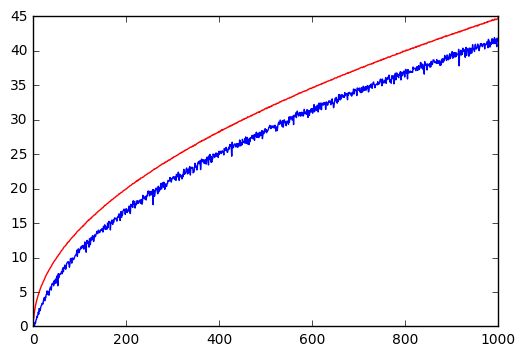

In [19]:
plt.plot(dimensions, avg_distances, '-r', dimensions, min_distances, '-b')

In [20]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]

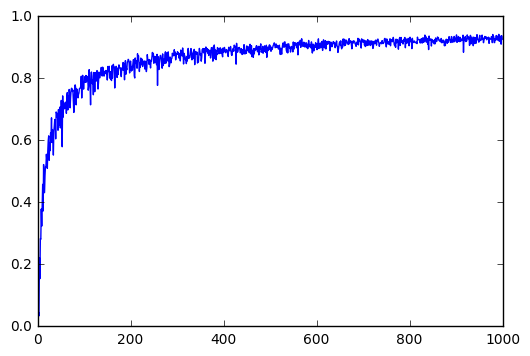

In [21]:
plt.plot(dimensions, min_avg_ratio)

## Remarks

- It has no model
- Instance-based classifier
- **k**: hyperparameter